In [1]:
from Bio.KEGG.KGML import KGML_parser
from Bio.KEGG import REST
from io import StringIO
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_geneid_mapping():
    """
    Fetch gene symbols for a list of KEGG gene IDs.
    """
    df_gene_info = pd.read_csv('data/geneinfo_beta.txt', sep='\t')  
    # create a map by using the columns 'gene_id' and 'gene_symbol'
    L1000_gene_map = df_gene_info.set_index('gene_id')['gene_symbol'].to_dict()
    # to every gene_id in the mapping add "hsa:" as a prefix
    L1000_gene_map = {f"hsa:{k}": v for k, v in L1000_gene_map.items()}
    return L1000_gene_map

In [3]:
def download_pathway(pathway_id):
    kgml = REST.kegg_get(pathway_id, "kgml").read()
    return KGML_parser.read(StringIO(kgml))

In [ ]:
# --- Step 1: Download and parse multiple KEGG pathways ---

# make a pathway id dictionary with pathway_name as key and pathway_id as value
pathway_id_dict = {
    "MAPK_signaling": "hsa04010",
    "T_cell_receptor_signaling": "hsa04660",
    "TGF-beta_signaling": "hsa04350",
    "p53_signaling": "hsa04115",
    "Pathways_in_cancer": "hsa05200",
    "mtor_signaling": "hsa04150"
}

pathways = ["p53_signaling"]
NETWORK_NAME = "TP53"
base_node= "TP53" #node that should define the subgraph, if none largest component is used

pathways = [download_pathway(pathway_id) for pathway_id in [
    pathway_id_dict[pathway] for pathway in pathways
]]



In [9]:
# --- Create Graph from pathways ---

gene_id_to_symbol = get_geneid_mapping()
G = nx.DiGraph()
id_to_gene_ids = {}      # maps KEGG node ID to list of gene IDs (e.g. ['hsa:7157', 'hsa:1029'])

added_genes = 0
skipped_entirely = 0

# --- Build individual gene nodes ---
for pw in pathways:
    for gene in pw.genes:
        gene_ids = gene.name.split()
        for gid in gene_ids:
            if gid not in gene_id_to_symbol:
                continue
            else:
                G.add_node(gid, label=gene_id_to_symbol[gid], type="gene")
                added_genes += 1
            id_to_gene_ids[gene.id] = [gid for gid in gene_ids if gid in gene_id_to_symbol]

print(f"✅ Added {added_genes} Genes to the graph.")



# write a text file with the node names
with open(f"../data/{NETWORK_NAME}_nodes.txt", "w") as f:
    for node in G.nodes():
        f.write(f"\"{gene_id_to_symbol[node]}\",")



activation = ["activation", "expression"]
inhibition = ["inhibition", "repression"]
other = ["compound", "hidden compound", "indirect effect", "state change", "binding/association", 
         "dissociation", "missing interaction", "phosphorylation", "dephosphorylation", "glycosylation", 
         "ubiquitination", "methylation"]

activating_edges = 0
inhibiting_edges = 0
skipped_edges = 0

# --- Add edges between gene nodes ---
for pw in pathways:
    for rel in pw.relations:
        src_id = rel.entry1.id
        tgt_id = rel.entry2.id

        # Only add edge if both sides are gene-type nodes
        if src_id in id_to_gene_ids and tgt_id in id_to_gene_ids:
            src_genes = id_to_gene_ids[src_id]
            tgt_genes = id_to_gene_ids[tgt_id]

            for subtype in rel.subtypes:
                interaction = subtype[0]
                # Determine the type of interaction based on the subtype
                if interaction in activation:
                    interaction = "1"
                    activating_edges += len(src_genes) * len(tgt_genes)
                elif interaction in inhibition:
                    interaction = "2"
                    inhibiting_edges += len(src_genes) * len(tgt_genes)
                elif interaction in other:
                    interaction = "3"
                    skipped_edges += len(src_genes) * len(tgt_genes)
                    continue
                else:
                    "⚠️ Unknown interaction type: {interaction} (subtype: {subtype})"

                # Connect each source gene to each target gene
                for src_gene in src_genes:
                    for tgt_gene in tgt_genes:
                        G.add_edge(src_gene, tgt_gene, interaction=interaction)

G = nx.relabel_nodes(G, {node: G.nodes[node]["label"] for node in G.nodes() if "label" in G.nodes[node]})

print(f"✅ Added {G.number_of_edges()} edges to the graph.")
print(f"✅ {activating_edges} activating edges, {inhibiting_edges} inhibiting edges, "
      f"{skipped_edges} skipped edges due to unknown interaction types.")



✅ Added 72 Genes to the graph.
✅ Added 57 edges to the graph.
✅ 55 activating edges, 8 inhibiting edges, 10 skipped edges due to unknown interaction types.


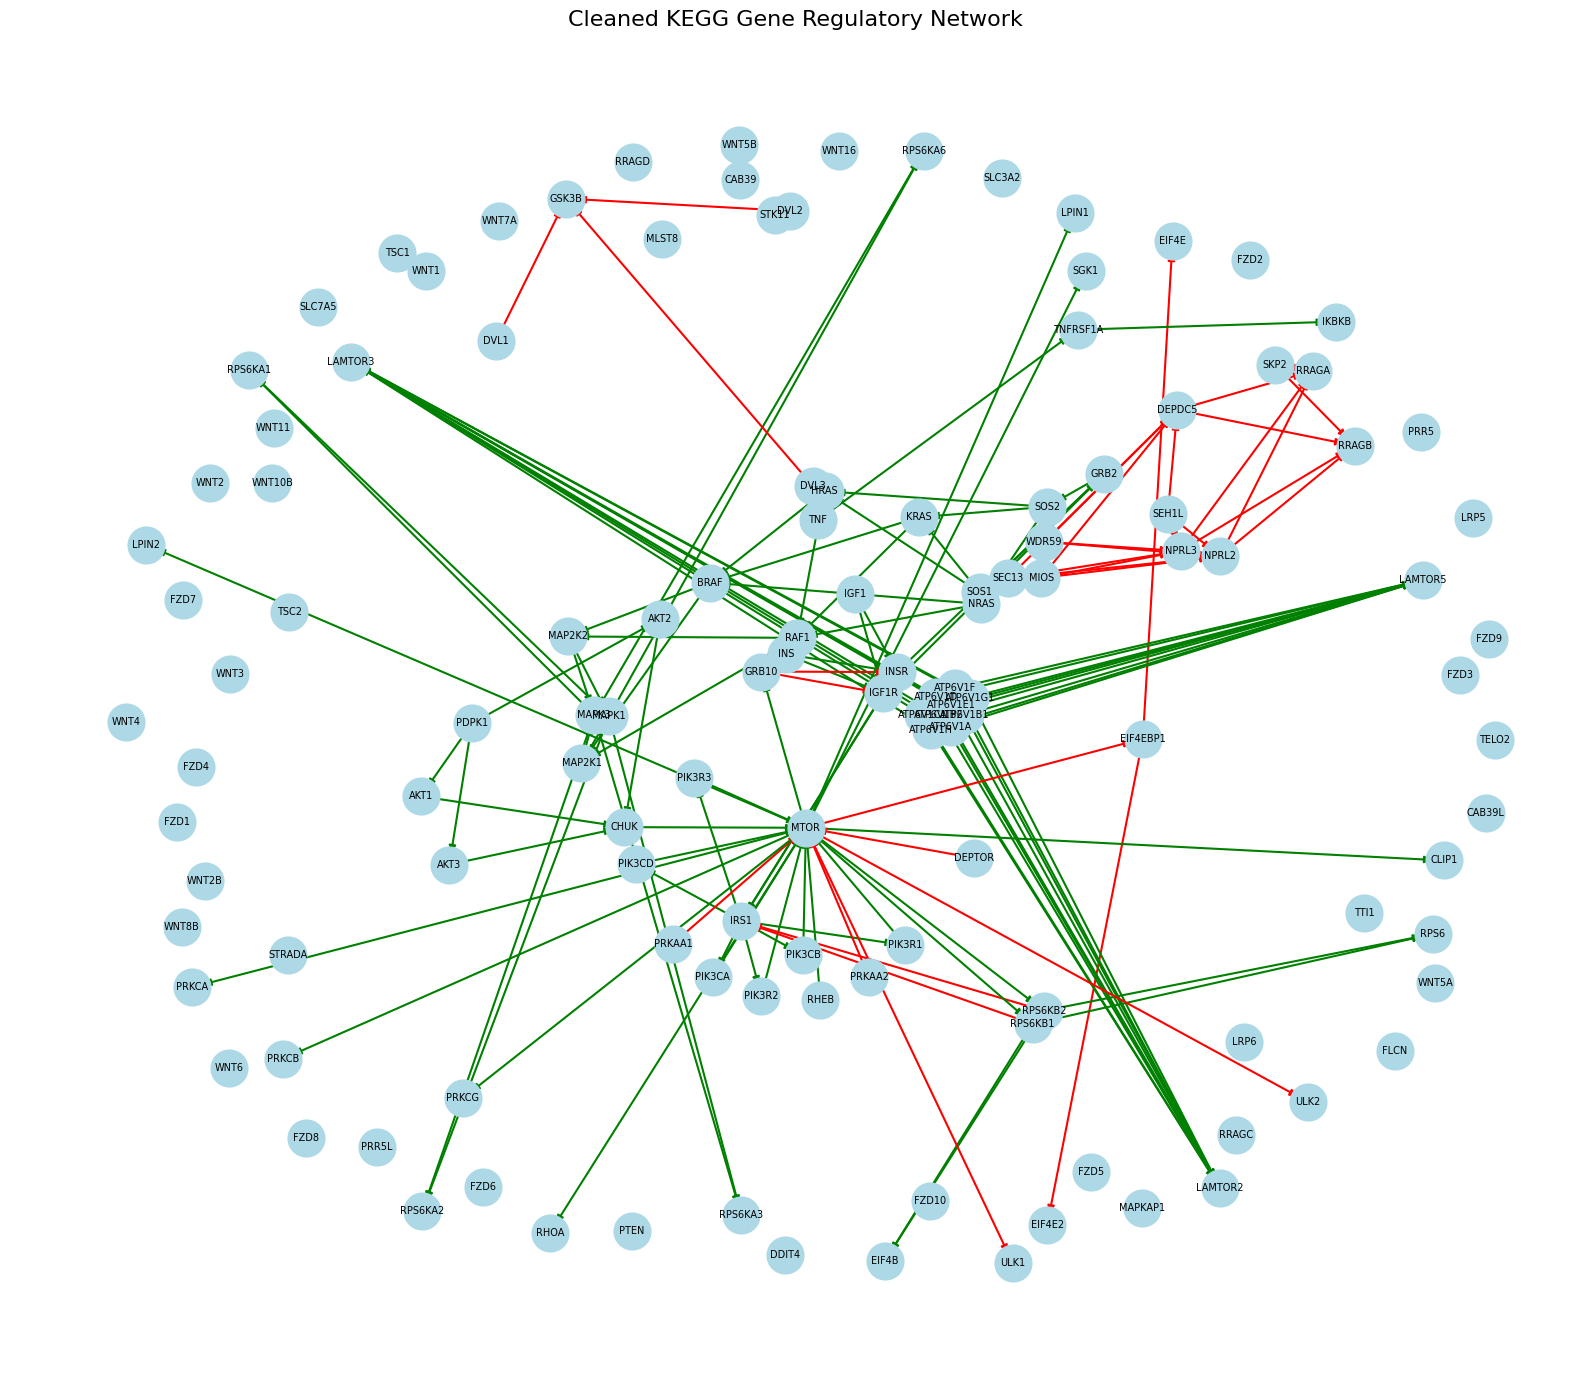

In [7]:
# --- Generalize Edge types ---
# 1: activating edges
# 2: inhibiting edges
# 3: other interactions


# for node in G.nodes():
#     if G.nodes[node].get("label"):
#         G = nx.relabel_nodes(G, {node: G.nodes[node]["label"]})

G_cleaned = G.copy()

# Step 4: Visualize the cleaned graph
pos = nx.spring_layout(G_cleaned, k=0.3)
labels = nx.get_node_attributes(G_cleaned, "label")
# edge color : green for activation, red for inhibition, gray for others

color_map = {"1": "green", "2": "red", "3": "gray"}  # Map interaction types to colors
edge_colors = [color_map[d["interaction"]] for u, v, d in G_cleaned.edges(data=True)]
fig, ax = plt.subplots(figsize=(16, 14))
nx.draw_networkx_nodes(G_cleaned, pos, node_color="lightblue", node_size=700, ax=ax)
nx.draw_networkx_labels(G_cleaned, pos, labels, font_size=7, ax=ax)
# Draw edges
nx.draw_networkx_edges(G_cleaned, pos, edge_color=edge_colors, width=1.5, ax=ax)

plt.title("Cleaned KEGG Gene Regulatory Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

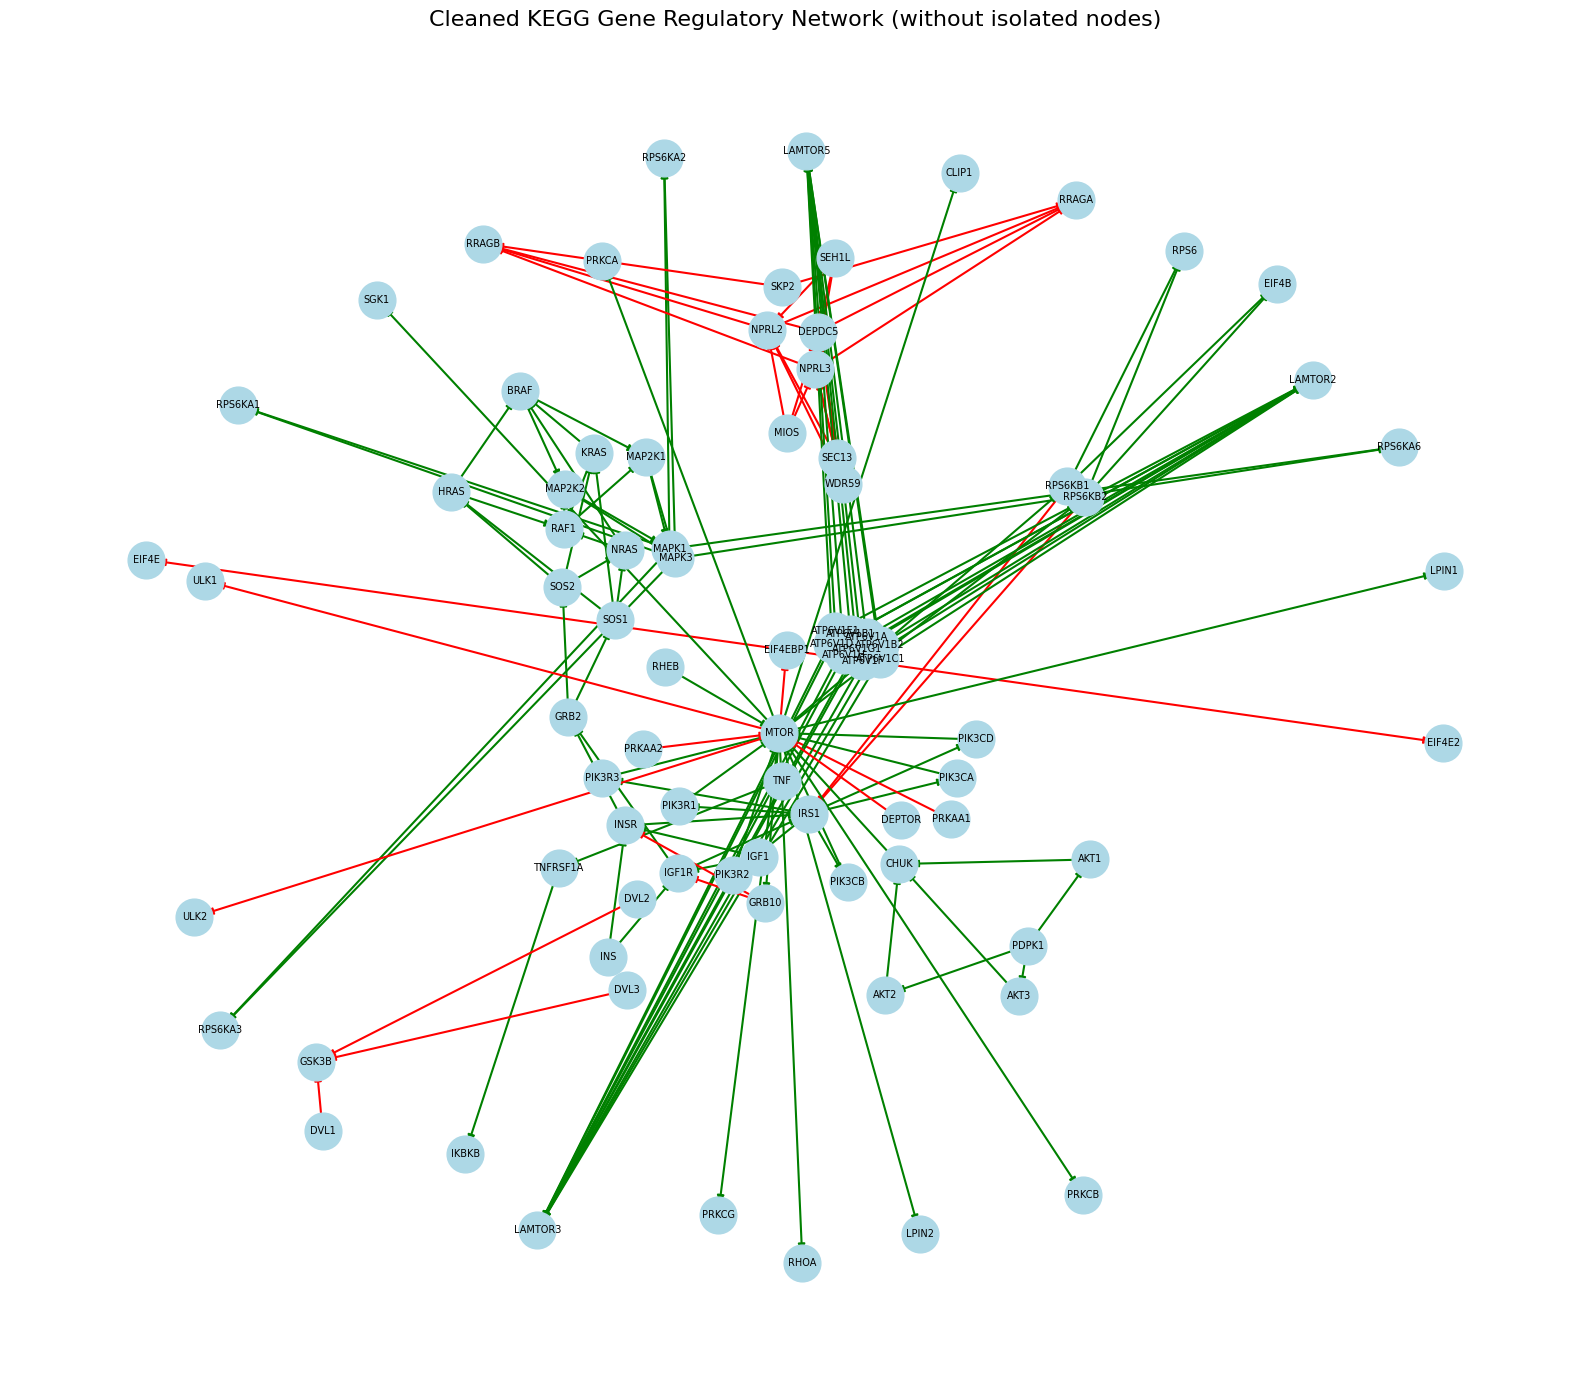

In [8]:
# remove all isolated nodes
isolated_nodes = list(nx.isolates(G_cleaned))
G_cleaned.remove_nodes_from(isolated_nodes) 

# plot the cleaned graph again
pos = nx.spring_layout(G_cleaned, k=0.3)
labels = nx.get_node_attributes(G_cleaned, "label")
edge_colors = [color_map[d["interaction"]] for u, v, d in G_cleaned.edges(data=True)]
fig, ax = plt.subplots(figsize=(16, 14))
nx.draw_networkx_nodes(G_cleaned, pos, node_color="lightblue", node_size=700, ax=ax)
nx.draw_networkx_labels(G_cleaned, pos, labels, font_size=7, ax=ax)
# Draw edges
nx.draw_networkx_edges(G_cleaned, pos, edge_color=edge_colors, width=1.5, ax=ax)
plt.title("Cleaned KEGG Gene Regulatory Network (without isolated nodes)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

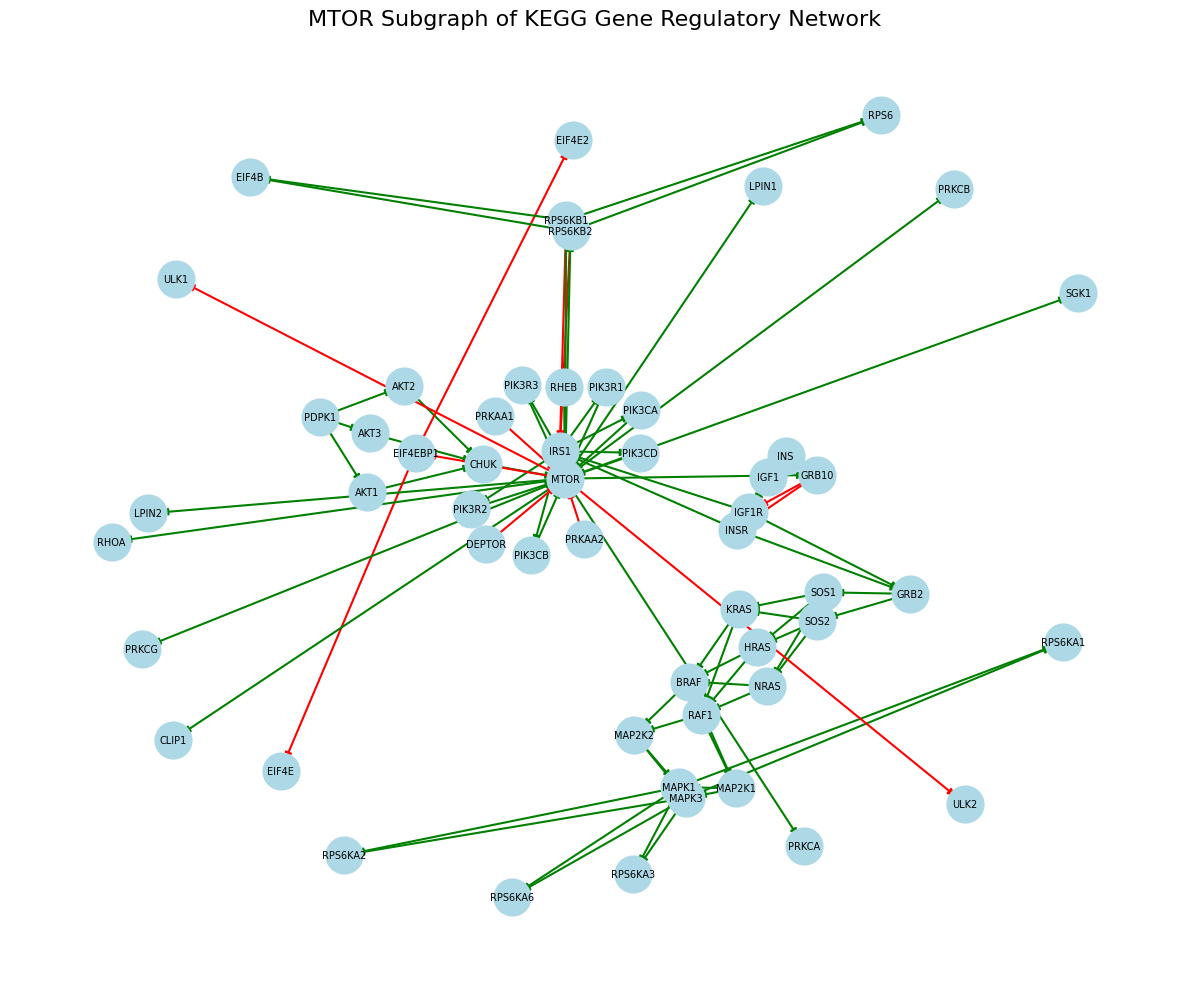

In [9]:
# 1. Check that base_node exists

if base_node:
    if base_node in G_cleaned:
        # 2. Get the weakly connected component that includes base_node
        for component in nx.weakly_connected_components(G_cleaned):
            if base_node in component:
                base_node_component = component
                break

        # 3. Create the subgraph from this component
        base_node_subgraph = G_cleaned.subgraph(base_node_component).copy()
else:
    # if base_node is none use the largest component instead
    largest_component = max(nx.weakly_connected_components(G_cleaned), key=len)
    base_node_subgraph = G_cleaned.subgraph(largest_component).copy()
    
# Visualize the base_node subgraph
pos_base_node_subgraph = nx.spring_layout(base_node_subgraph, k=0.3)
labels_base_node_subgraph = nx.get_node_attributes(base_node_subgraph, "label")
edge_colors_base_node = [color_map[d["interaction"]] for u, v, d in base_node_subgraph.edges(data=True)]

fig_base_node, ax_base_node = plt.subplots(figsize=(12, 10))
nx.draw_networkx_nodes(base_node_subgraph, pos_base_node_subgraph, node_color="lightblue", node_size=700, ax=ax_base_node)
nx.draw_networkx_labels(base_node_subgraph, pos_base_node_subgraph, labels_base_node_subgraph, font_size=7, ax=ax_base_node)
nx.draw_networkx_edges(base_node_subgraph, pos_base_node_subgraph, edge_color=edge_colors_base_node, width=1.5, ax=ax_base_node)

plt.title(f"{NETWORK_NAME} Subgraph of KEGG Gene Regulatory Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()
    

In [ ]:
from pathlib import Path
def create_topo_file_from_graph(network_name, G: nx.DiGraph, dir):
    """
    Create a 
     file as expected by racipe from a nx Graph
    and store it in the const.TOPO_PATH directory.
    :param G: nx Graph
    """
    new_file_path = Path(dir) / f"{network_name}.topo" 
    # save graph to a trrust.topo file with the header Source Target Type
    with open(new_file_path, "w") as f:
        f.write("Source Target Type\n")
        for u, v, d in G.edges(data='interaction'):

            f.write(f"{u} {v} {d}\n")

# Create topo file
create_topo_file_from_graph(NETWORK_NAME, base_node_subgraph, "../data/topos")

In [ ]:
for node in base_node_subgraph.nodes():
    if base_node_subgraph.nodes[node].get("label"):
        base_node_subgraph = nx.relabel_nodes(base_node_subgraph, {node: base_node_subgraph.nodes[node]["label"]})

# write a text file with the node names
with open(f"../data/subgraph_{NETWORK_NAME}_nodes.txt", "w") as f:
    for node in base_node_subgraph.nodes():
        f.write(f"{node}\n")

# print number of edges
print(f"Final graph has {len(base_node_subgraph.nodes())} nodes and {len(base_node_subgraph.edges())} edges.")

Final graph has 109 nodes and 187 edges.


In [ ]:
nx.write_graphml(base_node_subgraph, f"subgraph_{base_node_subgraph}_kegg.graphml")

In [ ]:
df_gene_info = pd.read_csv('data/geneinfo_beta.txt', sep='\t')       # Metadata for genes (the features of the data matrices)
df_sig_info = pd.read_csv('data/siginfo_beta.txt', sep='\t')       # Metadata for level 5 profiles
df_comp_info = pd.read_csv('data/compoundinfo_beta.txt', sep='\t')   # Metadata for cell lines 

df_sig_info_perturbed = df_sig_info[df_sig_info['pert_type'].str.contains('trt_oe|trt_sh|trt_xpr')]
df_sig_info_gene = pd.merge(df_sig_info_perturbed, df_gene_info, left_on='cmap_name', right_on='gene_symbol', how='inner')
df_sig_info_gene = df_sig_info_gene[['sig_id', 'cmap_name', 'pert_id', 'pert_type', 'pert_mfc_id', 'cell_iname', 'pert_idose', 'pert_time', 'gene_symbol', 'feature_space']]
df_sig_info_gene = df_sig_info_gene.rename(columns={'gene_symbol': 'affected_gene'})

df_sig_info_cp = df_sig_info[df_sig_info['pert_type'].str.contains('trt_cp')]
df_cp_target_info = pd.merge(df_sig_info_cp, df_comp_info, on='pert_id', how='inner')

df_cp_target_info = df_cp_target_info[['sig_id','cmap_name_x', 'pert_id', 'pert_type', 'pert_mfc_id', 'cell_iname', 'pert_idose', 'pert_time', 'target']]
# rename cmap_name_x to cmap_name
df_cp_target_info.rename(columns={'cmap_name_x': 'cmap_name'}, inplace=True)
# rename target to affected_gene
df_cp_target_info.rename(columns={'target': 'affected_gene'}, inplace=True)

# join df_cp_target_info with df_gene_info to create a new dataframe with the columns 'sig_id', 'pert_id', 'pert_iname', 'cell_id', 'pert_idose', 'pert_time', target, feature_space
# join over the column target from df_cp_target_info and the column gene_symbol from df_gene_info
df_cp_target_info_gene = pd.merge(df_cp_target_info, df_gene_info, left_on='affected_gene', right_on='gene_symbol', how='inner')
df_cp_target_info_gene = df_cp_target_info_gene[['sig_id', 'cmap_name', 'pert_id', 'pert_type', 'pert_mfc_id', 'cell_iname', 'pert_idose', 'pert_time', 'affected_gene', 'feature_space']]
df_sig_info_target = pd.concat([df_cp_target_info_gene, df_sig_info_gene])

/tmp/ipykernel_6554/1384557722.py:2: DtypeWarning: Columns (0,3,4,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sig_info = pd.read_csv('data/siginfo_beta.txt', sep='\t')       # Metadata for level 5 profiles


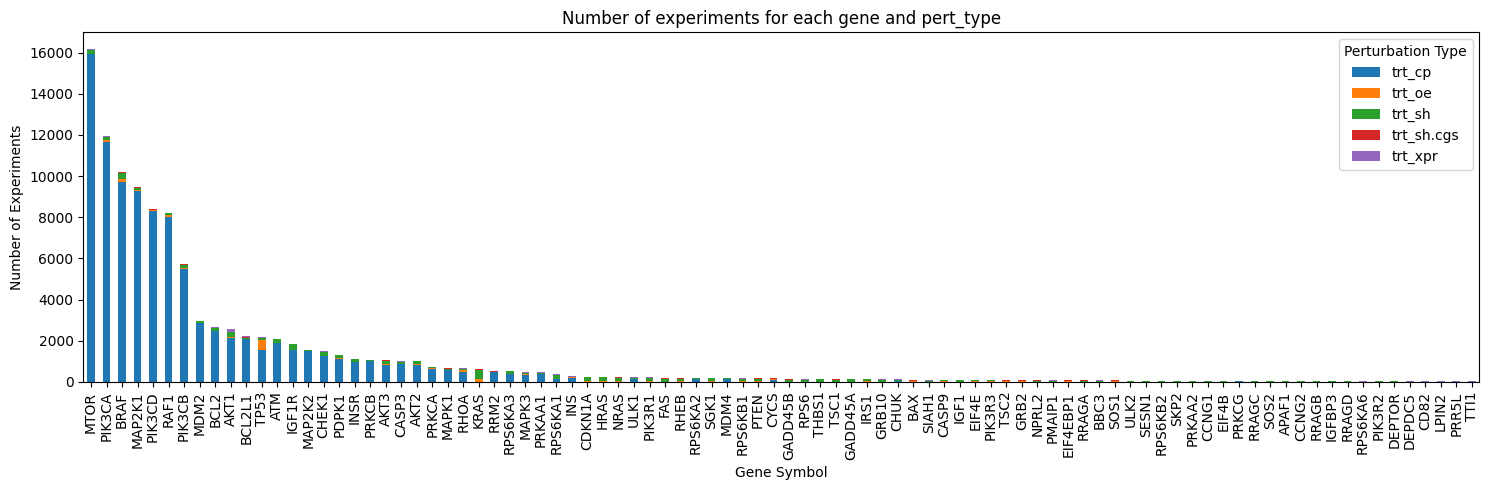

In [ ]:
# read the genes listed in the file ../data/cancer_cellline_genes.txt
# create a bar that for each gene shows the number of experiments in df_sig_info_target that have that gene as affected_gene
genes_in_graph = set(base_node_subgraph.nodes())
df_experiments_choosen_genes = df_sig_info_target[df_sig_info_target['affected_gene'].isin(genes_in_graph)]
# Group and unstack as before
plot_data = df_experiments_choosen_genes.groupby(['affected_gene', 'pert_type']).size().unstack(fill_value=0)
# Sort by total count descending
plot_data = plot_data.loc[plot_data.sum(axis=1).sort_values(ascending=False).index]
plot_data.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.title('Number of experiments for each gene and pert_type')
plt.xlabel('Gene Symbol')
plt.ylabel('Number of Experiments')
plt.xticks(rotation=90)
plt.legend(title='Perturbation Type')
plt.tight_layout()
plt.show()

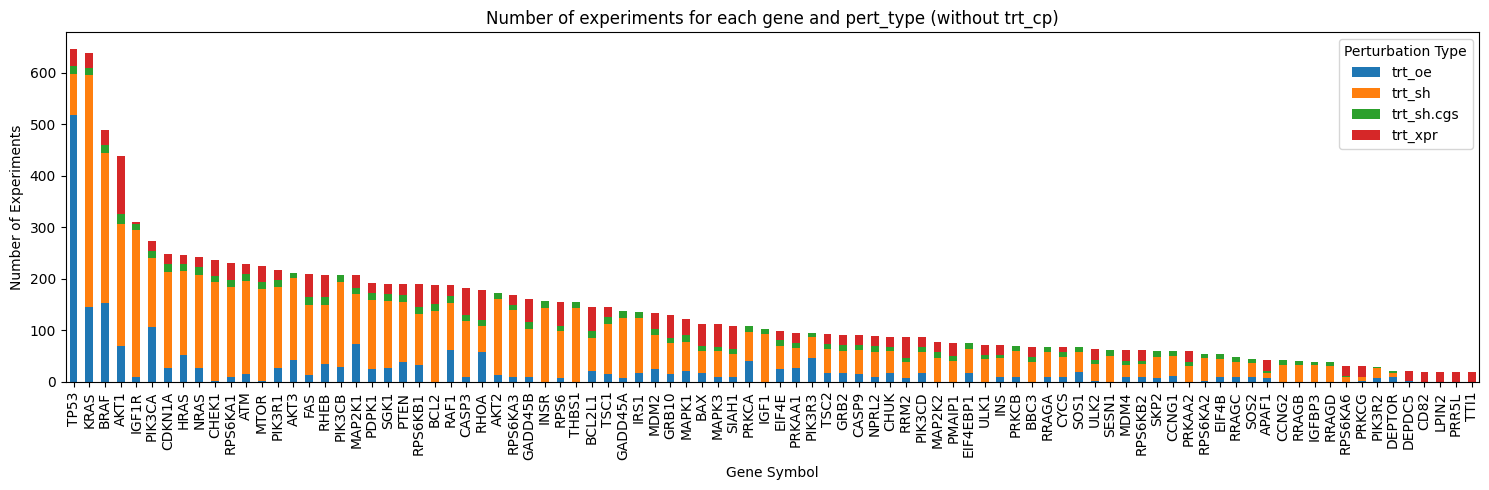

In [ ]:
# do the same but filter out trt_cp
df_experiments_choosen_genes_no_cp = df_experiments_choosen_genes[~df_experiments_choosen_genes['pert_type'].str.contains('trt_cp')].copy()
# Group and unstack as before
plot_data_no_cp = df_experiments_choosen_genes_no_cp.groupby(['affected_gene', 'pert_type']).size().unstack(fill_value=0)
# Sort by total count descending
plot_data_no_cp = plot_data_no_cp.loc[plot_data_no_cp.sum(axis=1).sort_values(ascending=False).index]
plot_data_no_cp.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.title('Number of experiments for each gene and pert_type (without trt_cp)')
plt.xlabel('Gene Symbol')
plt.ylabel('Number of Experiments')
plt.xticks(rotation=90)
plt.legend(title='Perturbation Type')
plt.tight_layout()
plt.show()

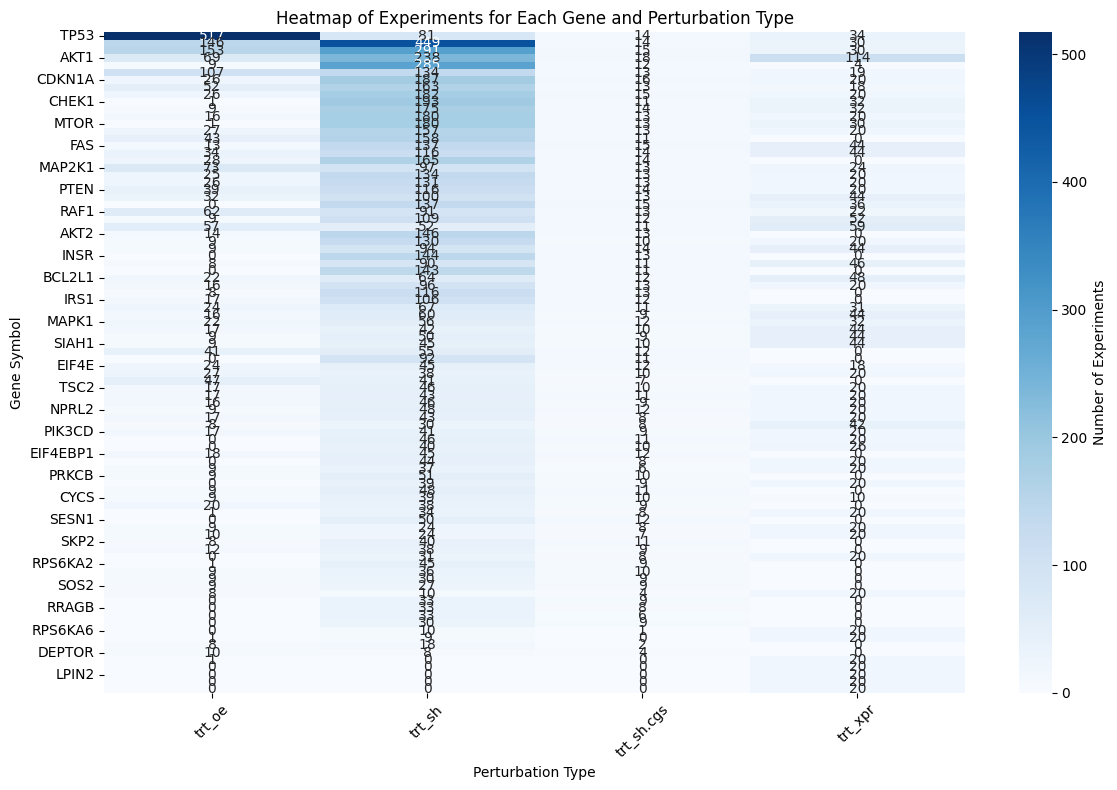

In [ ]:
# instead of a bar plot, create a heatmap, showing the number of experiments for each gene per cell line
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(plot_data_no_cp, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Experiments'})
plt.title('Heatmap of Experiments for Each Gene and Perturbation Type')
plt.xlabel('Perturbation Type')
plt.ylabel('Gene Symbol')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

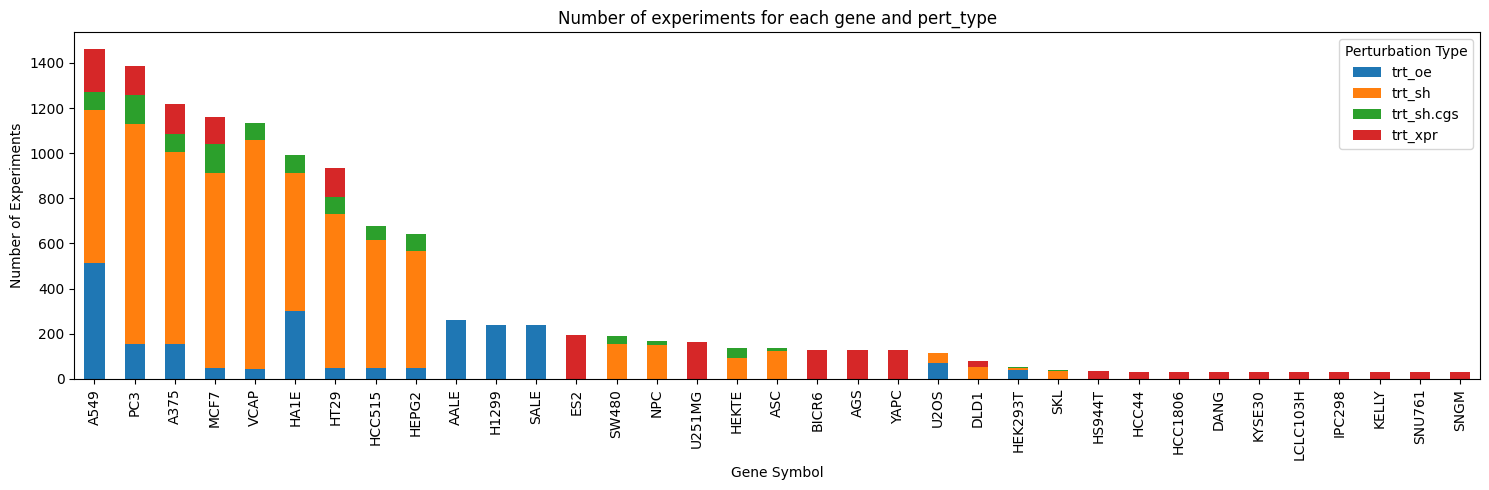

In [ ]:

df_experiments_choosen_genes = df_sig_info_target[df_sig_info_target['affected_gene'].isin(genes_in_graph)]
# filter out trt_cp perturbations
df_experiments_choosen_genes = df_experiments_choosen_genes[~df_experiments_choosen_genes['pert_type'].str.contains('trt_cp')].copy()
# Group and unstack as before
plot_data = df_experiments_choosen_genes.groupby(['cell_iname', 'pert_type']).size().unstack(fill_value=0)
# remove all groups that have less than 10 experiments
plot_data = plot_data.loc[plot_data.sum(axis=1) >= 20]
# Sort by total count descending
plot_data = plot_data.loc[plot_data.sum(axis=1).sort_values(ascending=False).index]
plot_data.plot(kind='bar', stacked=True, figsize=(15, 5))
plt.title('Number of experiments for each gene and pert_type')
plt.xlabel('Gene Symbol')
plt.ylabel('Number of Experiments')
plt.xticks(rotation=90)
plt.legend(title='Perturbation Type')
plt.tight_layout()
plt.show()


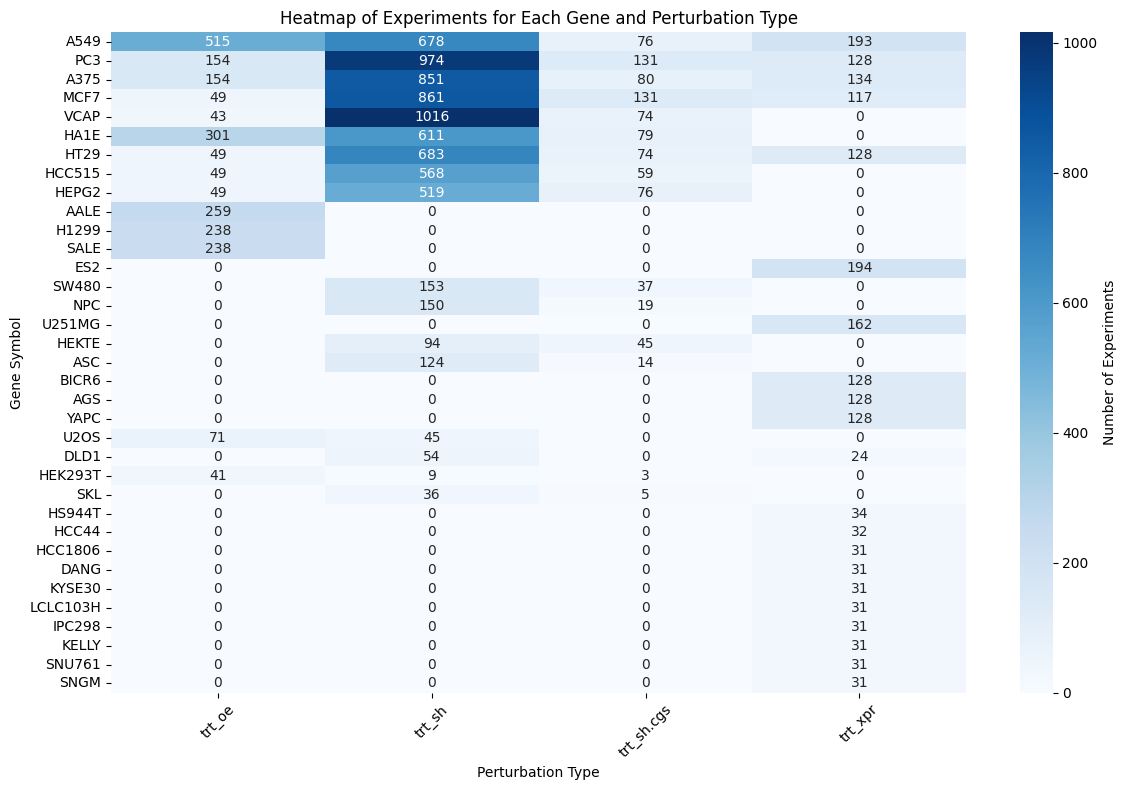

In [ ]:
# create a heatmap, showing the number of experiments for each gene per cell line
plt.figure(figsize=(12, 8))
sns.heatmap(plot_data, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Number of Experiments'})
plt.title('Heatmap of Experiments for Each Gene and Perturbation Type')
plt.xlabel('Perturbation Type')
plt.ylabel('Gene Symbol')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()